In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

import time

Using TensorFlow backend.


In [2]:
frame_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

In [3]:

# Build an encoder that takes in neighbouring frames, interpolates them in latent space
# then compares the decoded result to the input image.

def encode_input_frame(frame):
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(frame)
    x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    shape_before_flattening = K.int_shape(x)

    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)

    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    
    return z_mean, z_log_var, shape_before_flattening

# Define the left input frame
input_frame_left = keras.Input(shape=frame_shape)

# Encode left frame:
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_frame_left)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening_left = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean_left = layers.Dense(latent_dim)(x)
z_log_var_left = layers.Dense(latent_dim)(x)


# Define the middle input frame
input_frame_middle = keras.Input(shape=frame_shape)


# Define the right input frame
input_frame_right = keras.Input(shape=frame_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_frame_right)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening_right = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean_right = layers.Dense(latent_dim)(x)
z_log_var_right = layers.Dense(latent_dim)(x)


# # Define the encoder
# z_mean_left, z_log_var_left, shape_before_flattening_left = encode_input_frame(input_frame_left)
# z_mean_right, z_log_var_right, shape_before_flattening_right = encode_input_frame(input_frame_right)

if shape_before_flattening_left != shape_before_flattening_right:
    raise Exception('Shape before flattening must match on all input frames')

shape_before_flattening = shape_before_flattening_left

In [4]:
# Define the interpolation
def interpolate_z_means(args):
    z_mean_left, z_mean_right = args
    return 0.5*(z_mean_left + z_mean_right)

def interpolate_z_log_vars(args):
    z_log_var_left, z_log_var_right = args
    return 0.5*K.sqrt(K.square(z_log_var_left) + K.square(z_log_var_right))

z_mean_interpolated = layers.Lambda(interpolate_z_means)([z_mean_left, z_mean_right])
z_log_var_interpolated = layers.Lambda(interpolate_z_log_vars)([z_log_var_left, z_log_var_right])

In [5]:
# Statistical sampling from the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon


# TODO: This is where the two branches merge and are interpolated for the decoder
z = layers.Lambda(sampling)([z_mean_interpolated, z_log_var_interpolated])

In [6]:
# Define the decoder
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

# We then apply then reverse operation to the initial
# stack of convolution layers: a `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same', activation='sigmoid')(x)
# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [7]:
# Define the loss function between the decoded interpolated frame and the original middle frame
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var_interpolated - K.square(z_mean_interpolated) - \
            K.exp(z_log_var_interpolated), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_frame_middle, z_decoded])

In [8]:
vae = Model(inputs=[input_frame_left, input_frame_middle, input_frame_right], output=y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

/Users/william.nelson/.pyenv/versions/3.6.1/envs/cv3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("cu...)`
  """Entry point for launching an IPython kernel.


In [9]:
from keras.datasets import mnist

## TODO: retrieve frames from generator

# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))


train_frame_left = x_train[0::3].copy()
train_frame_middle = x_train[1::3].copy()
train_frame_right = x_train[2::3].copy()


test_frame_left = x_test[0::3][0:2600].copy()
test_frame_middle = x_test[1::3][0:2600].copy()
test_frame_right = x_test[2::3][0:2600].copy()

In [10]:
start_time = time.time()

vae.fit([train_frame_left, train_frame_middle, train_frame_right],
        y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=([test_frame_left, test_frame_middle, test_frame_right], None))

end_time = time.time()
print('Elapsed time: {}'.format(end_time - start_time))

Train on 20000 samples, validate on 2600 samples
Epoch 1/10
20000/20000 [==============================] - 117s 6ms/step - loss: 68902.6527 - val_loss: 0.2591
Epoch 2/10
20000/20000 [==============================] - 114s 6ms/step - loss: 0.2633 - val_loss: 0.2585
Epoch 3/10
20000/20000 [==============================] - 114s 6ms/step - loss: 0.2632 - val_loss: 0.2583
Epoch 4/10
20000/20000 [==============================] - 115s 6ms/step - loss: 0.2632 - val_loss: 0.2583
Epoch 5/10
20000/20000 [==============================] - 115s 6ms/step - loss: 0.2631 - val_loss: 0.2584
Epoch 6/10
20000/20000 [==============================] - 115s 6ms/step - loss: 0.2631 - val_loss: 0.2584
Epoch 7/10
20000/20000 [==============================] - 116s 6ms/step - loss: 0.2631 - val_loss: 0.2582
Epoch 8/10
20000/20000 [==============================] - 116s 6ms/step - loss: 0.2630 - val_loss: 0.2584
Epoch 9/10
20000/20000 [==============================] - 115s 6ms/step - loss: 0.2631 - val_loss: 

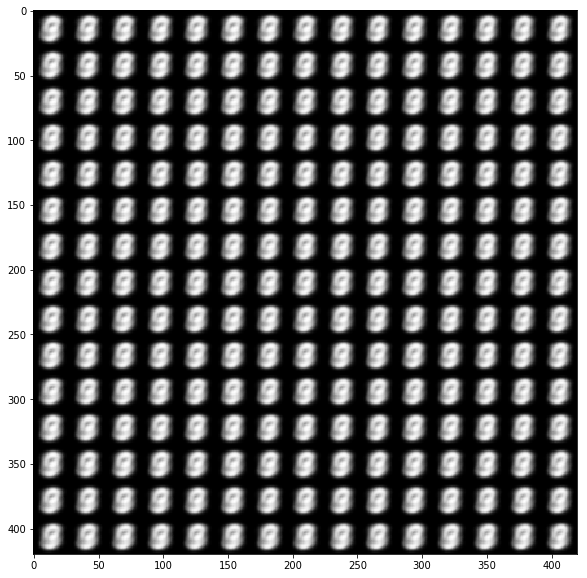

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline


# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()